In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

from kneed import KneeLocator
from math import ceil

In [16]:
# Lecture des fichiers 
path = "data"
dfs = dict()
for dir_item in os.listdir(path):
    dir_item_path = os.path.join(path, dir_item)
    print(dir_item_path)
    if os.path.isfile(dir_item_path) and dir_item_path[:8] == "data/Exp":
        dfs[dir_item] = pd.read_csv(dir_item_path, sep=";")
dfs.keys()

data/.ipynb_checkpoints
data/ExportBales.csv
data/README.md
data/ExportBales_2.csv
data/LICENSE
data/ExportBales_1.csv
data/ExportBales_4_1.csv
data/ExportBales_4.csv


dict_keys(['ExportBales.csv', 'ExportBales_2.csv', 'ExportBales_1.csv', 'ExportBales_4_1.csv', 'ExportBales_4.csv'])

In [3]:
dfs['ExportBales.csv'].head()

,_time,bale_info_bale_length,bale_info_bale_weight,bale_info_flake_count,bale_info_moisture,bale_info_tag_#,latitude,longitude,Colonne1,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2021-07-31T08:09:17Z,3200,211000,255,110000,1,52.115374,11.078973,1.0,NaN,NaN,NaN,NaN
1,2021-07-31T08:10:13Z,1960,361000,44,110000,2,52.115187,11.082384,1.0,NaN,NaN,NaN,NaN
2,2021-07-31T08:11:02Z,2440,445000,40,110000,3,52.115149,11.080707,1.0,NaN,NaN,NaN,NaN
3,2021-07-31T08:12:04Z,2410,430000,39,110000,4,52.115188,11.079040,1.0,NaN,NaN,NaN,NaN
4,2021-07-31T08:12:50Z,2430,454000,38,110000,5,52.115411,11.079829,1.0,NaN,NaN,NaN,NaN


In [4]:
def clustering(data, path, size_trailer=5, humidite_lim=(0,0)) :
    # Option de garder une fourchette d'humidité précise
    X = data.copy()
    if humidite_lim != (0,0):
        X = X.loc[(X["bale_info_moisture"] <= humidite_lim[0]) & (X["bale_info_moisture"] >= humidite_lim[1])]
    if X.shape[0] == 0:
        print("Il n'y a pas de ballots avec cette humidité")
        return
    # nettoyage
    X.drop(inplace=True, columns=X.columns[-5:])
    X = X.loc[:,["latitude", "longitude"]]

    # Clustering
    size_max = min(size_trailer, X.shape[0])
    print("Taille remorque :", size_max)
    n_cl = ceil(X.shape[0]/size_trailer)
    kmeans = KMeansConstrained(n_clusters=n_cl, size_max=size_max, n_init=50, max_iter=300, tol=0.0001, random_state=42)
    kmeans.fit(X)
    print("Nombre de clusters :", n_cl, "inertie :", kmeans.inertia_)
    centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=X.columns)

    # Plot des données et des centres 
    plt.figure(figsize=(19,10))
    labels = kmeans.labels_
    plt.scatter(X["latitude"], X["longitude"], c=labels, cmap="Paired")
    plt.scatter(centers["latitude"], centers["longitude"], marker="*", c=list(centers.index), s=500, cmap="Paired")
    plt.axis('equal')
    plt.show()
    
    # Export des données avec leur cluster + centres 
    X["cluster"] = labels
    X.to_csv("cluster/"+path[:-4]+"_cl.csv", index=False)
    centers["cluster"] = centers.index
    centers.to_csv("cluster/"+path[:-4]+"_centers.csv", index=False)

In [20]:
def clustering(data, path, size_trailer=5) :
    # nettoyage
    X=data.copy()
    X.drop(inplace=True, columns=X.columns[-5:])
    X = X.loc[:,["latitude", "longitude"]]

    # Clustering
    size_max = min(size_trailer, X.shape[0])
    n_cl = ceil(X.shape[0]/size_trailer)
    kmeans = KMeansConstrained(n_clusters=n_cl, size_max=size_max, n_init=50, max_iter=300, tol=0.0001, random_state=42)
    kmeans.fit(X)
    print("Nombre de clusters :", n_cl, "inertie :", kmeans.inertia_)
    centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=X.columns)

    '''# Plot des données et des centres 
    plt.figure(figsize=(19,10))
    labels = kmeans.labels_
    plt.scatter(X["latitude"], X["longitude"], c=labels, cmap="Paired")
    plt.scatter(centers["latitude"], centers["longitude"], marker="*", c=list(centers.index), s=500, cmap="Paired")
    plt.show()'''
    
    # Export des données avec leur cluster + centres 
    labels = kmeans.labels_
    X["cluster"] = labels
    print(X)
    X.to_csv("cluster/"+path[:-4]+"_cl.csv", index=False)
    centers["cluster"] = centers.index
    centers.to_csv("cluster/"+path[:-4]+"_centers.csv", index=False)
    
    size_camion = 2
    for i in range(n_cl) :
        cluster = X.loc[X["cluster"]==i]
        n_cl_camion = ceil(cluster.shape[0]/size_camion)
        kmeans_camion = KMeansConstrained(n_clusters=n_cl_camion, size_max=size_camion, n_init=50, max_iter=300, tol=0.0001, random_state=42)
        kmeans_camion.fit(cluster)
        centers_camion = pd.DataFrame(data=kmeans_camion.cluster_centers_, columns=X.columns)
        # Plot des données et des centres 
        plt.figure(figsize=(19,10))
        labels = kmeans_camion.labels_
        plt.scatter(cluster["latitude"], cluster["longitude"], c=labels, cmap="Paired")
        plt.scatter(X[X["cluster"]!=i]["latitude"], X[X["cluster"]!=i]["longitude"], c="lightgrey")
        plt.scatter(centers[centers["cluster"]!=i]["latitude"], centers[centers["cluster"]!=i]["longitude"], marker="*", c="lightgrey", s=500)
        plt.scatter(centers[centers["cluster"]==i]["latitude"], centers[centers["cluster"]==i]["longitude"], marker="*", c="black", s=500)

        plt.show()

ExportBales.csv
695
139
Nombre de clusters : 5 inertie : 749.1778383438766
      latitude  longitude  cluster
0    52.115374  11.078973        1
1    52.115187  11.082384        1
2    52.115149  11.080707        1
3    52.115188  11.079040        1
4    52.115411  11.079829        1
..         ...        ...      ...
690  51.333125   5.565565        2
691  51.334698   5.568261        2
692  51.334773   5.568318        2
693  51.334706   5.567996        2
694  51.334671   5.567956        2

[695 rows x 3 columns]


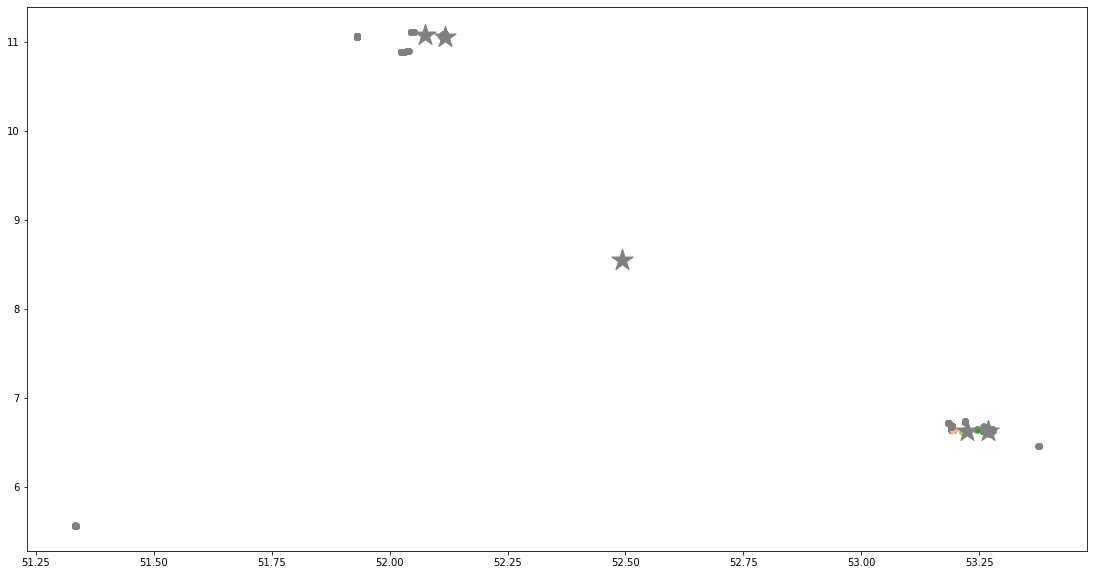

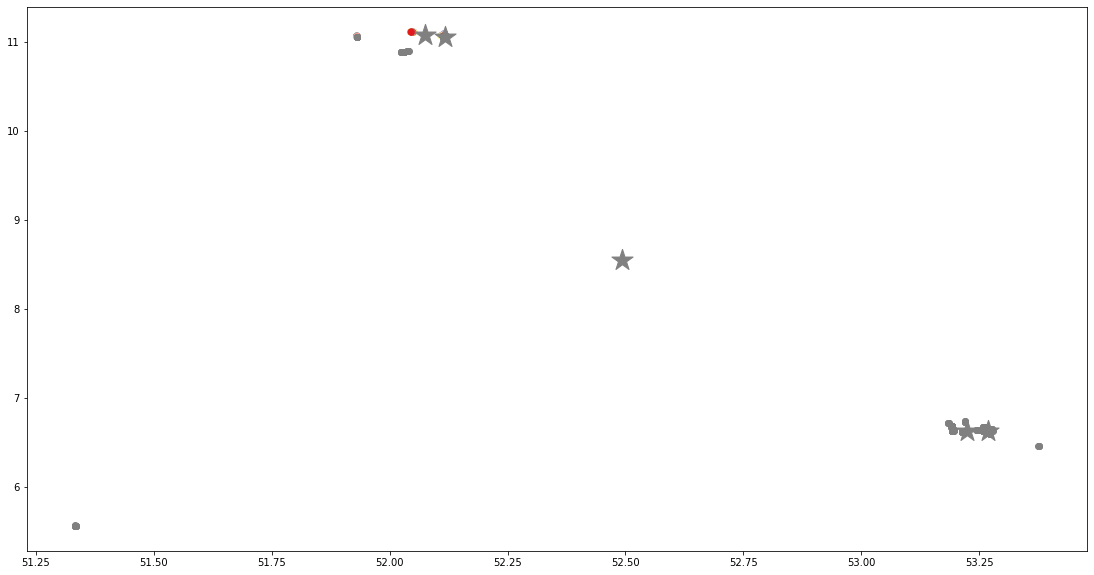

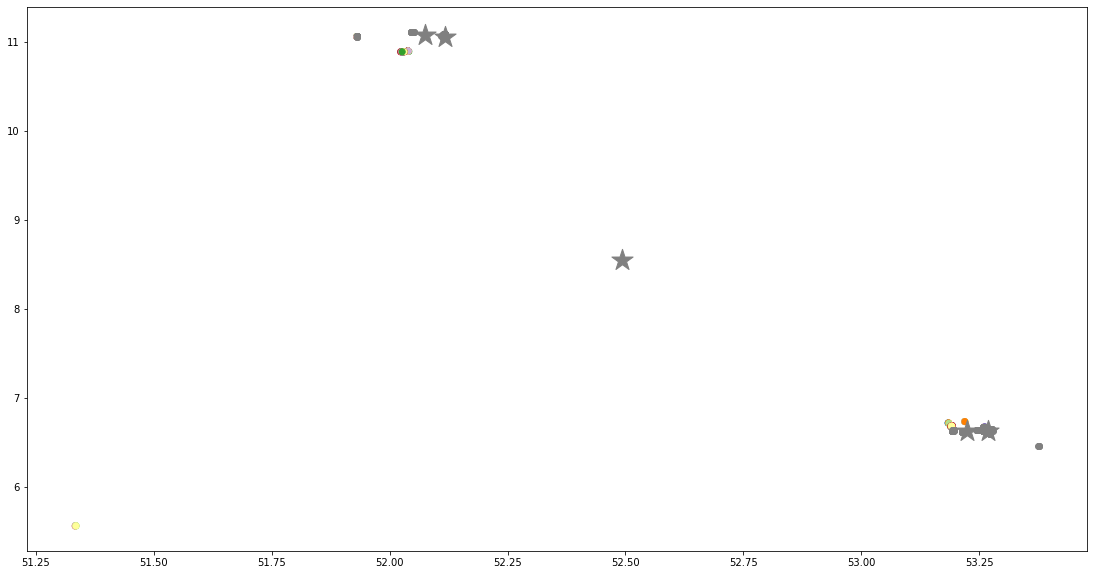

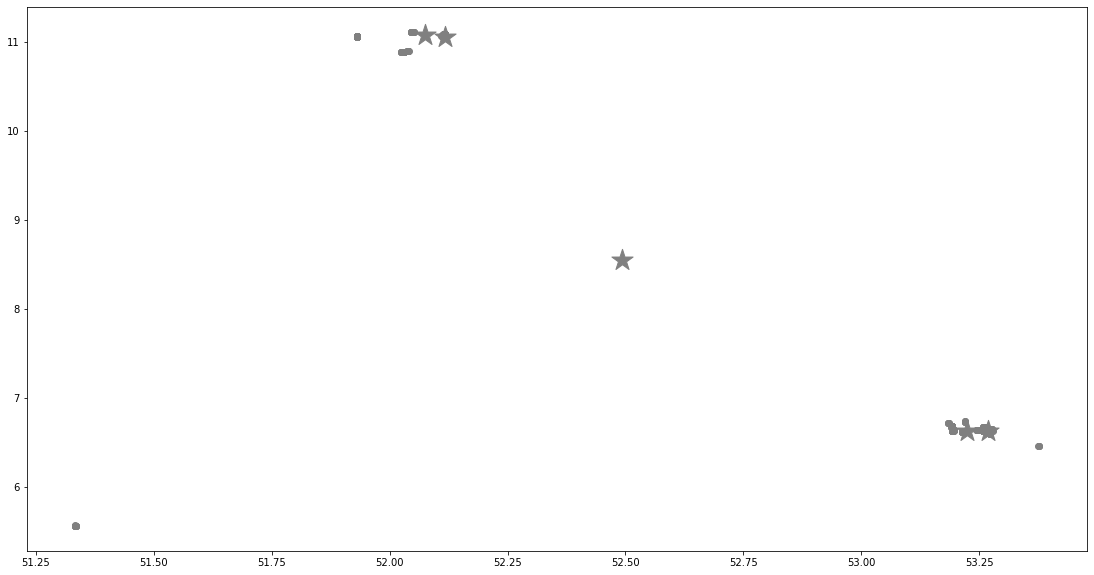

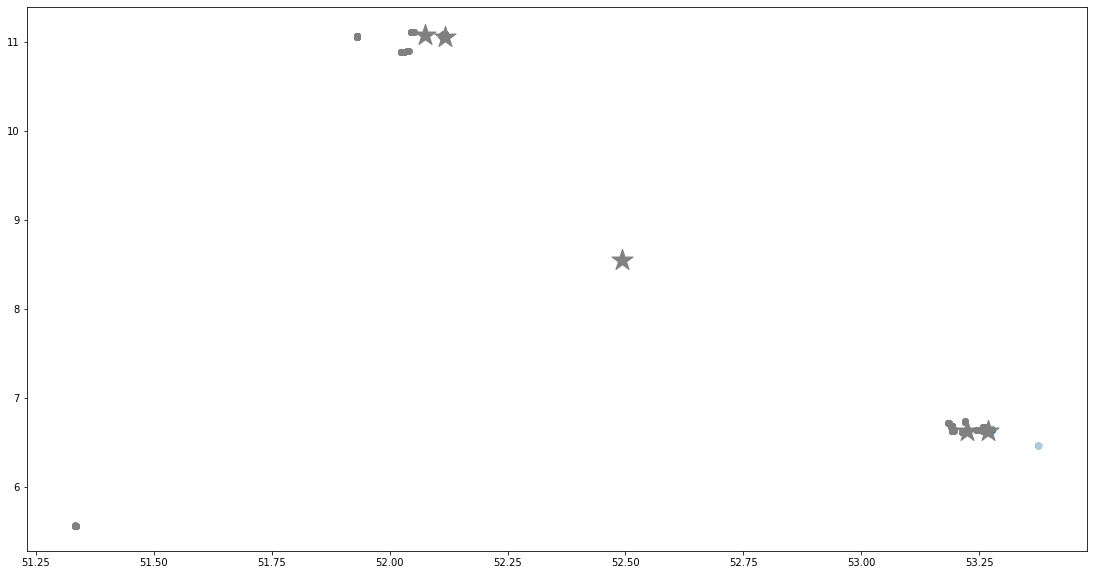

ExportBales_2.csv
18
5
Nombre de clusters : 4 inertie : 1.489601157251205e-06
     latitude  longitude  cluster
0   52.116077  11.083267        3
1   52.116089  11.085686        2
2   52.116138  11.084403        1
3   52.116165  11.083136        0
4   52.116232  11.083386        3
5   52.116208  11.084310        1
6   52.116166  11.085495        2
7   52.116275  11.085149        2
8   52.116293  11.084331        1
9   52.116326  11.083135        0
10  52.116405  11.082807        0
11  52.116376  11.083880        3
12  52.116357  11.084805        2
13  52.116440  11.084763        1
14  52.116478  11.083629        3
15  52.116502  11.082610        0
16  52.116549  11.083111        0
17  52.116512  11.084755        1


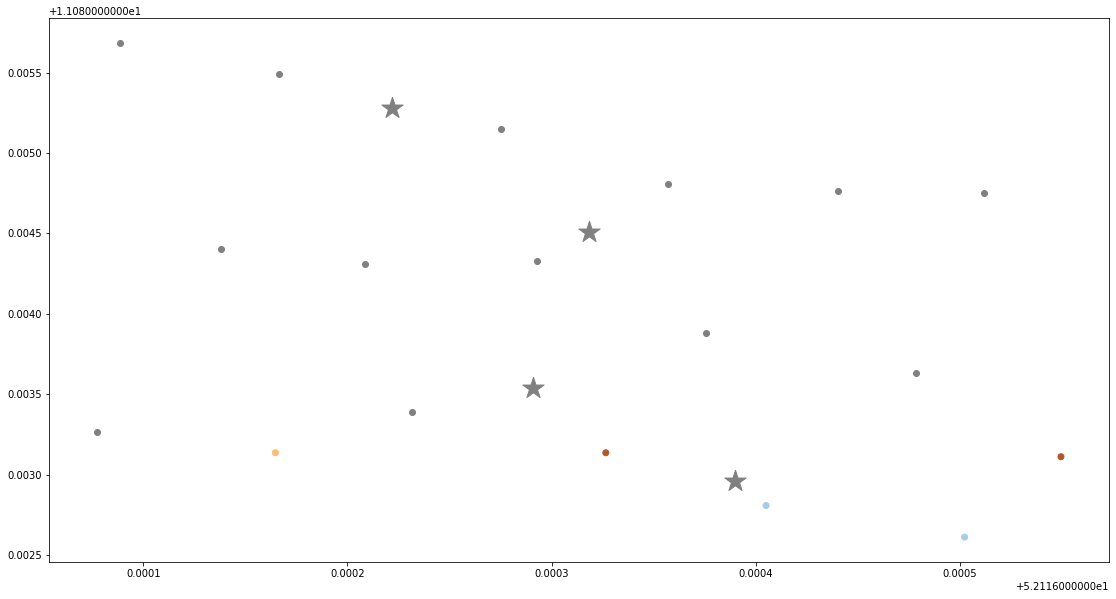

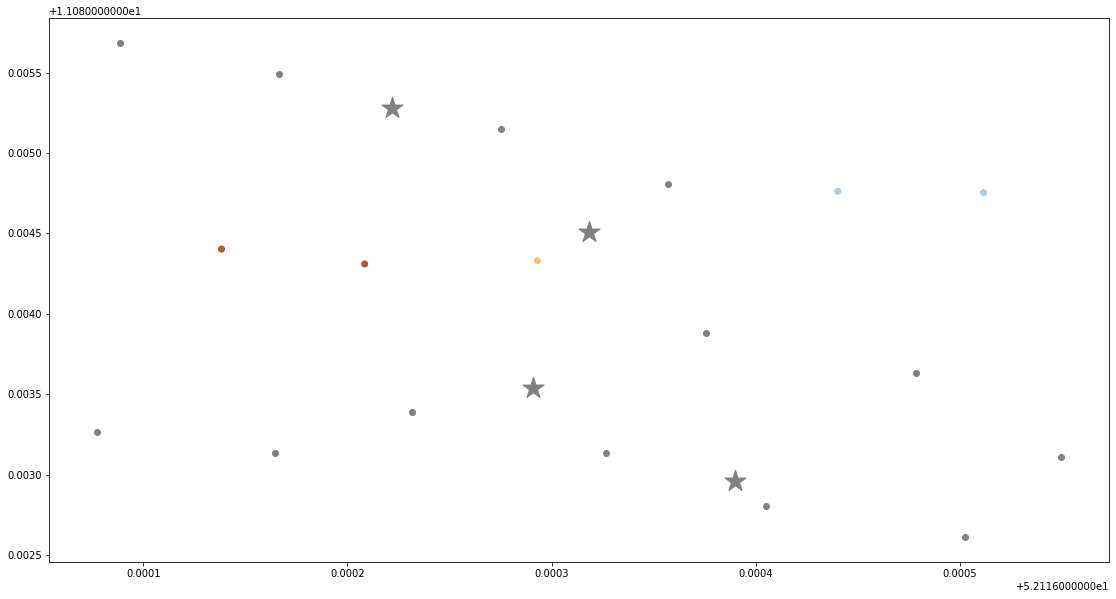

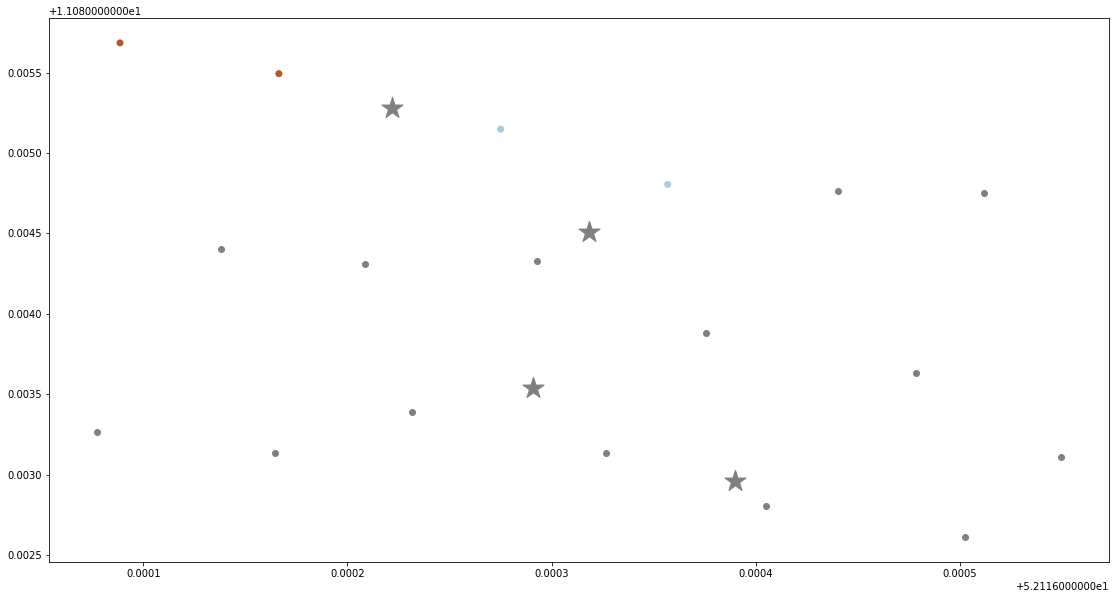

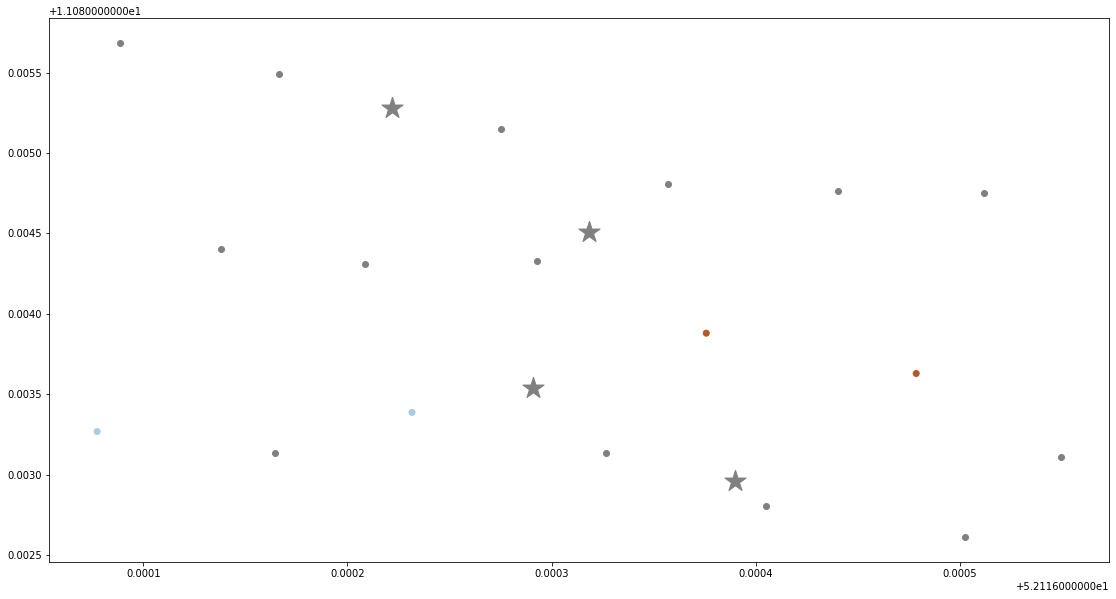

ExportBales_1.csv
18
5
Nombre de clusters : 4 inertie : 5.857043552499338e-06
     latitude  longitude  cluster
0   52.115374  11.078973        1
1   52.115187  11.082384        2
2   52.115149  11.080707        3
3   52.115188  11.079040        1
4   52.115411  11.079829        3
5   52.115257  11.079463        1
6   52.115479  11.079626        3
7   52.115429  11.081506        2
8   52.115068  11.080748        3
9   52.115085  11.079170        1
10  52.115843  11.081508        2
11  52.115897  11.079028        1
12  52.115908  11.081440        2
13  52.115734  11.084846        0
14  52.115858  11.085725        0
15  52.115896  11.084514        0
16  52.115945  11.082991        2
17  52.115967  11.084042        0


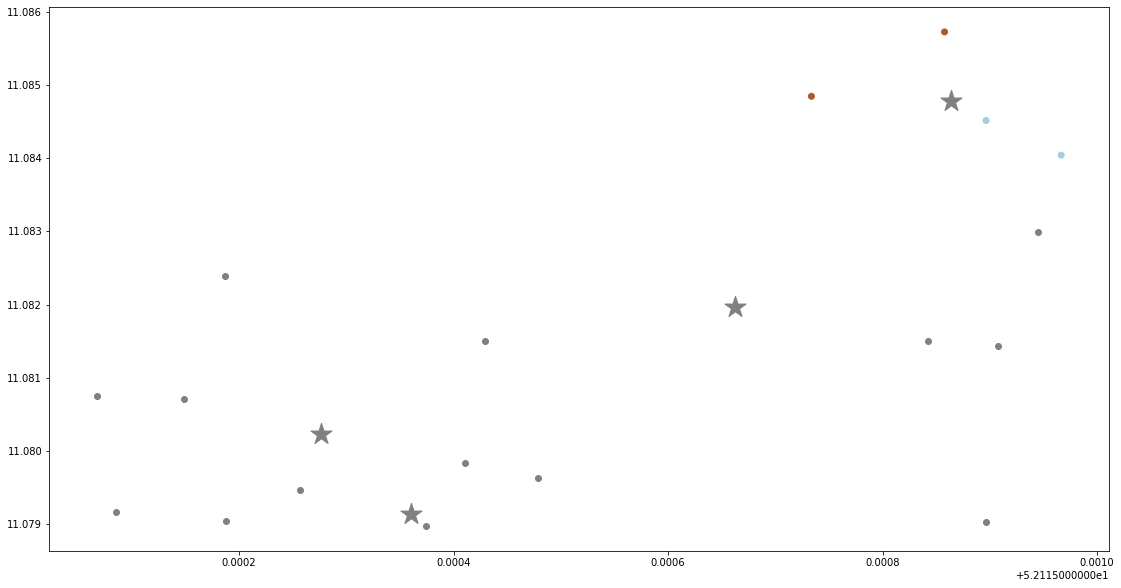

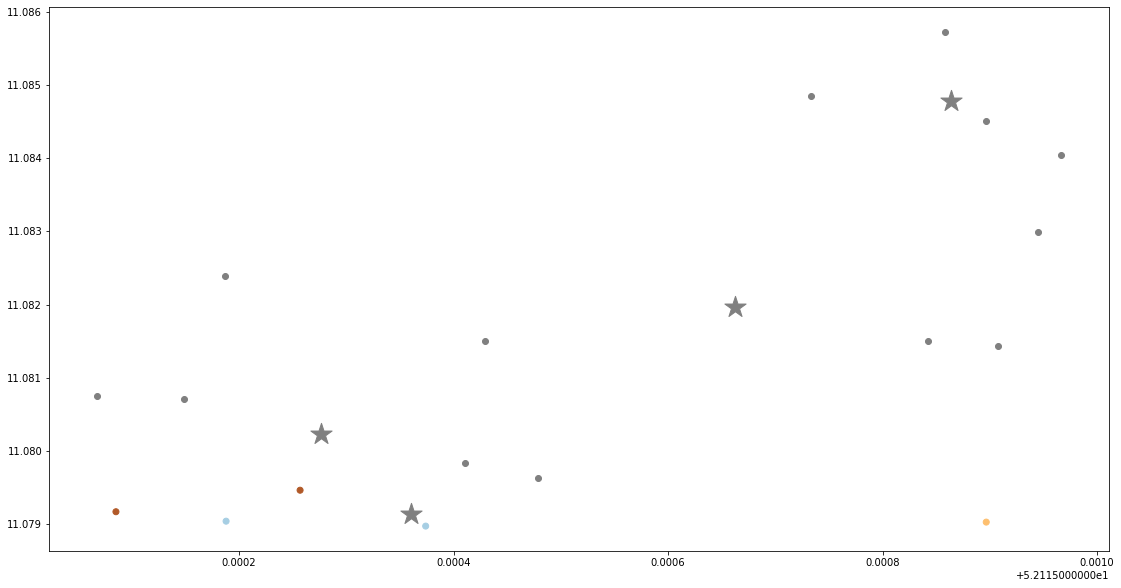

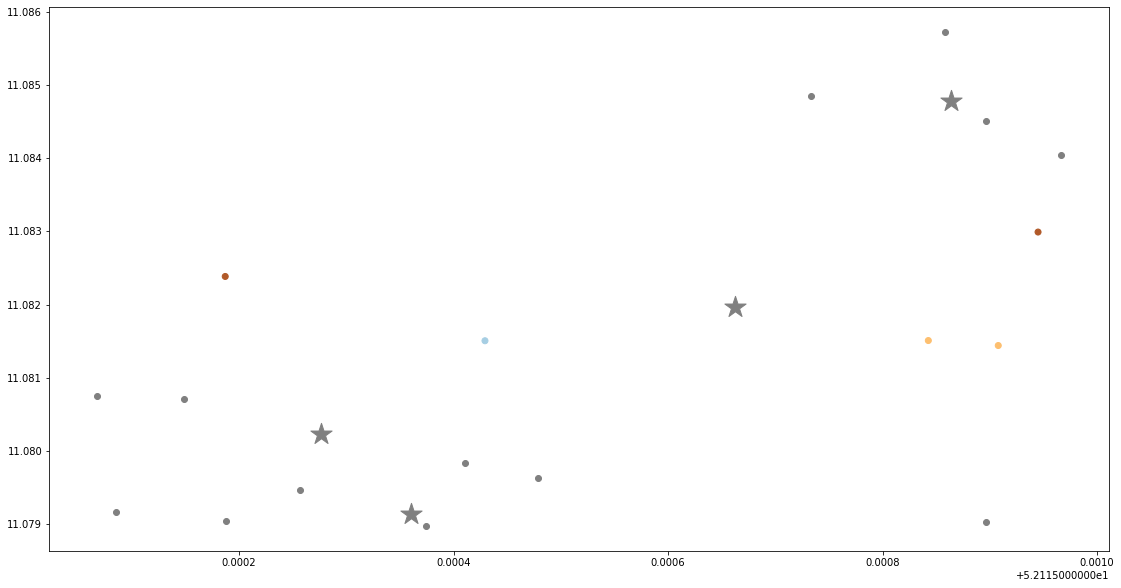

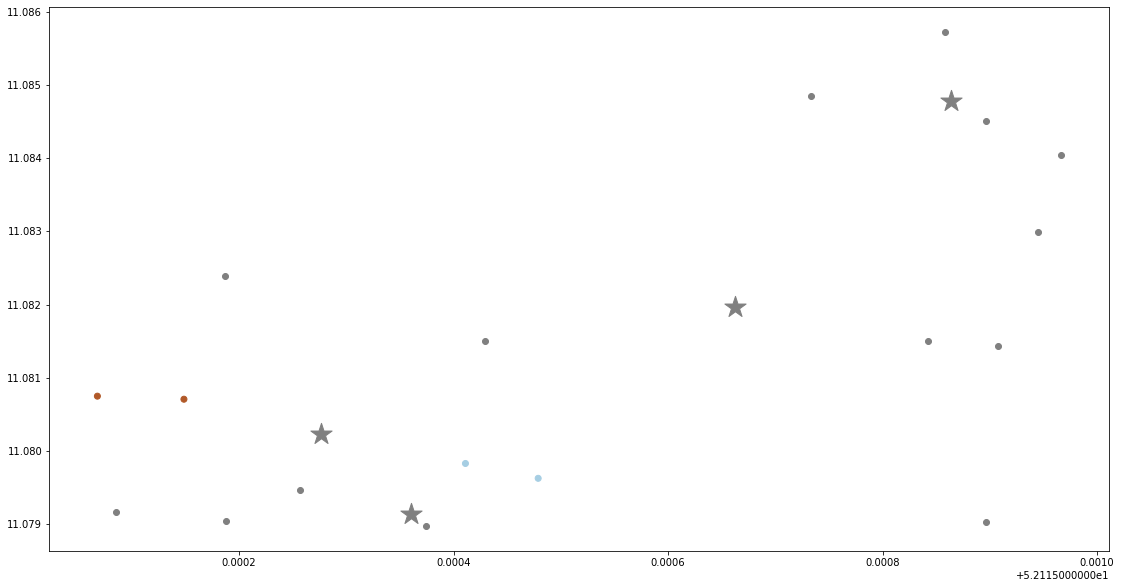

ExportBales_4_1.csv
46
9
Nombre de clusters : 6 inertie : 5.648274277989831e-06
     latitude  longitude  cluster
0   52.119048  11.049098        1
1   52.118592  11.048978        1
2   52.117585  11.048704        5
3   52.117585  11.048704        5
4   52.117084  11.048575        2
5   52.116575  11.048433        2
6   52.116068  11.048297        4
7   52.115515  11.048187        4
8   52.115066  11.048068        4
9   52.114532  11.047926        0
10  52.113994  11.047772        0
11  52.113536  11.047664        3
12  52.113030  11.047527        3
13  52.113039  11.047360        3
14  52.113540  11.047501        3
15  52.114026  11.047636        0
16  52.114632  11.047783        0
17  52.115205  11.047948        4
18  52.115783  11.048115        4
19  52.116426  11.048291        2
20  52.116988  11.048454        2
21  52.117512  11.048605        5
22  52.118082  11.048761        5
23  52.118597  11.048892        1
24  52.119174  11.049043        1
25  52.119639  11.048994        1
26

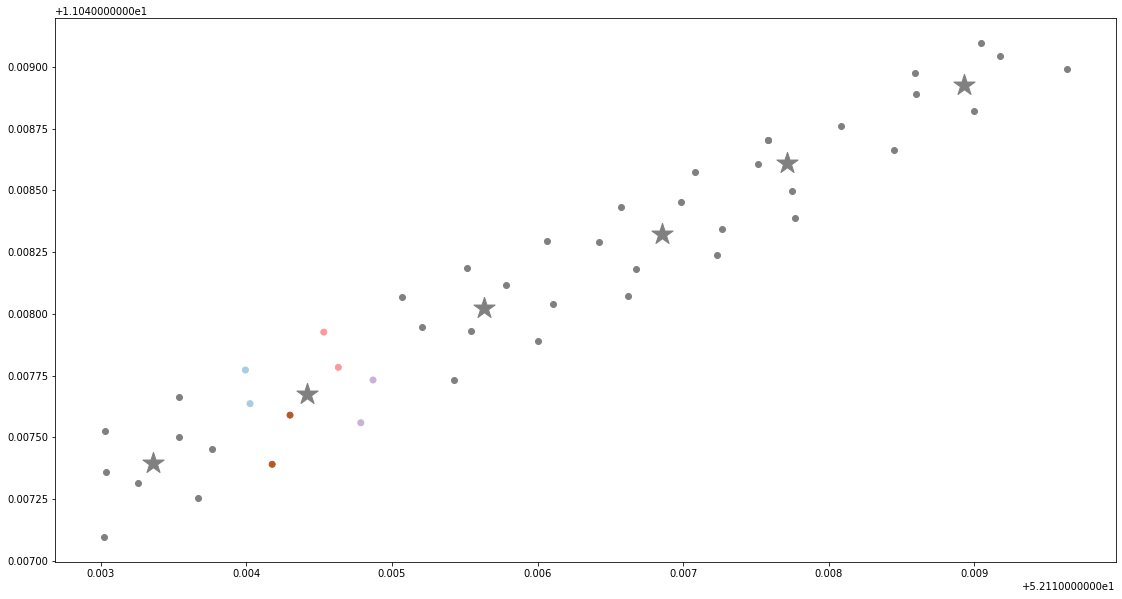

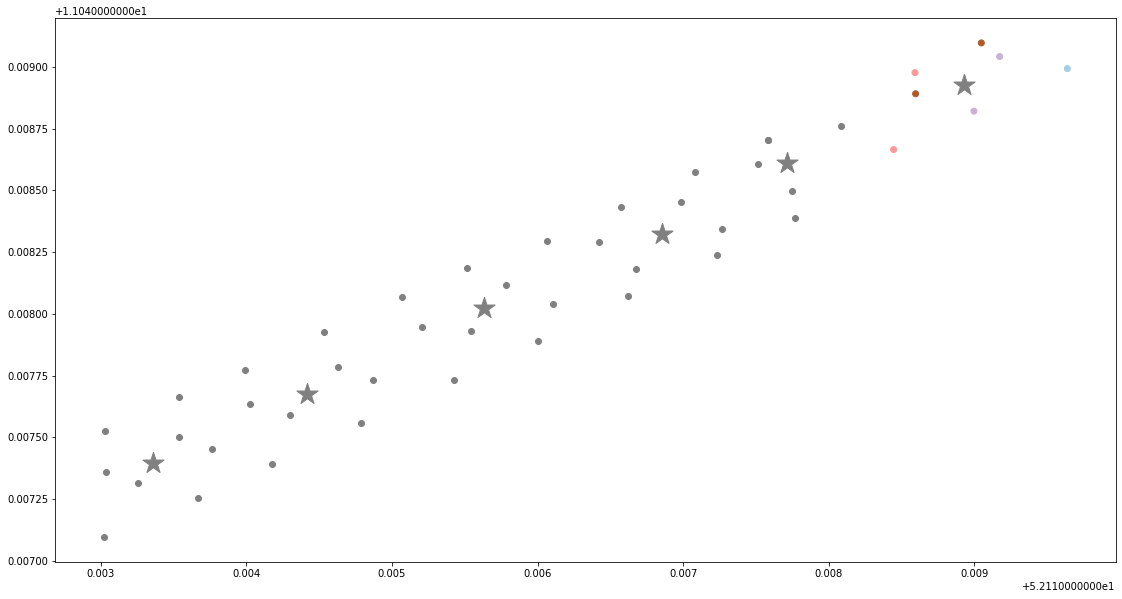

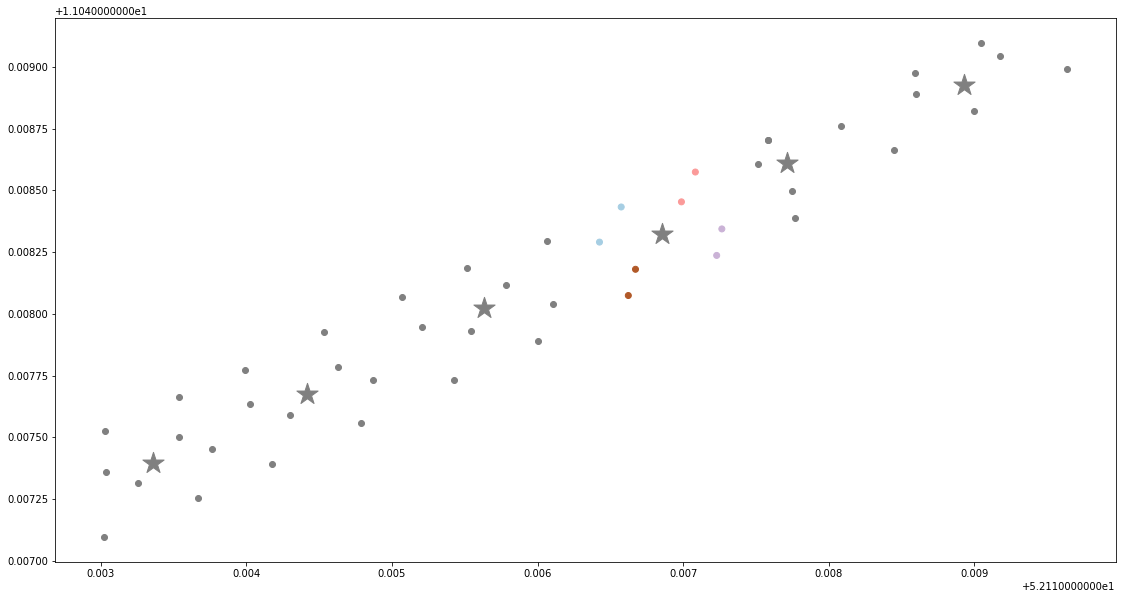

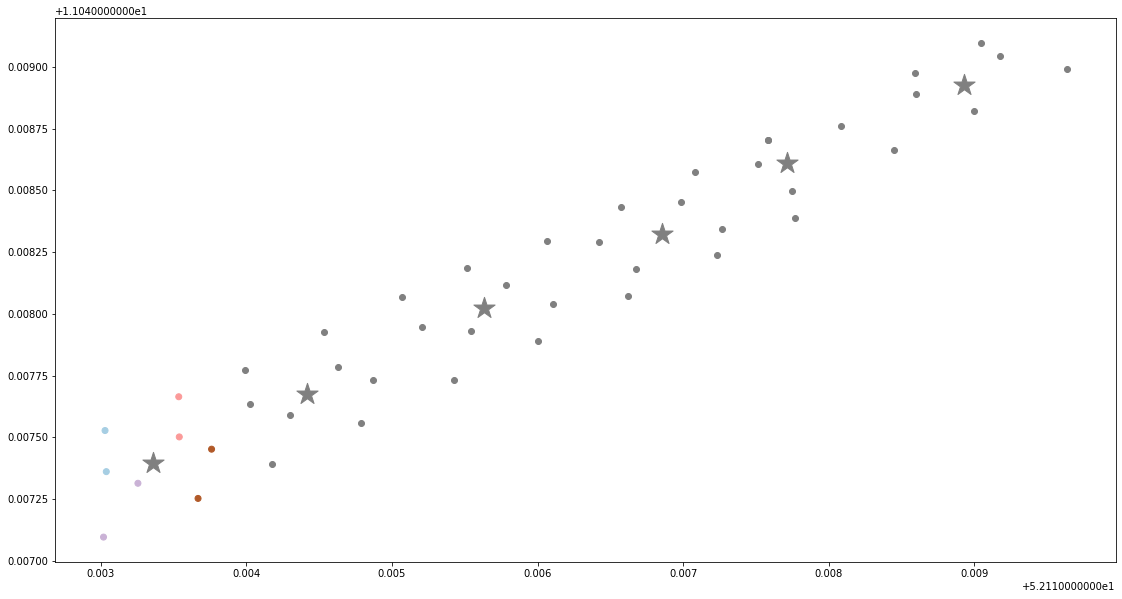

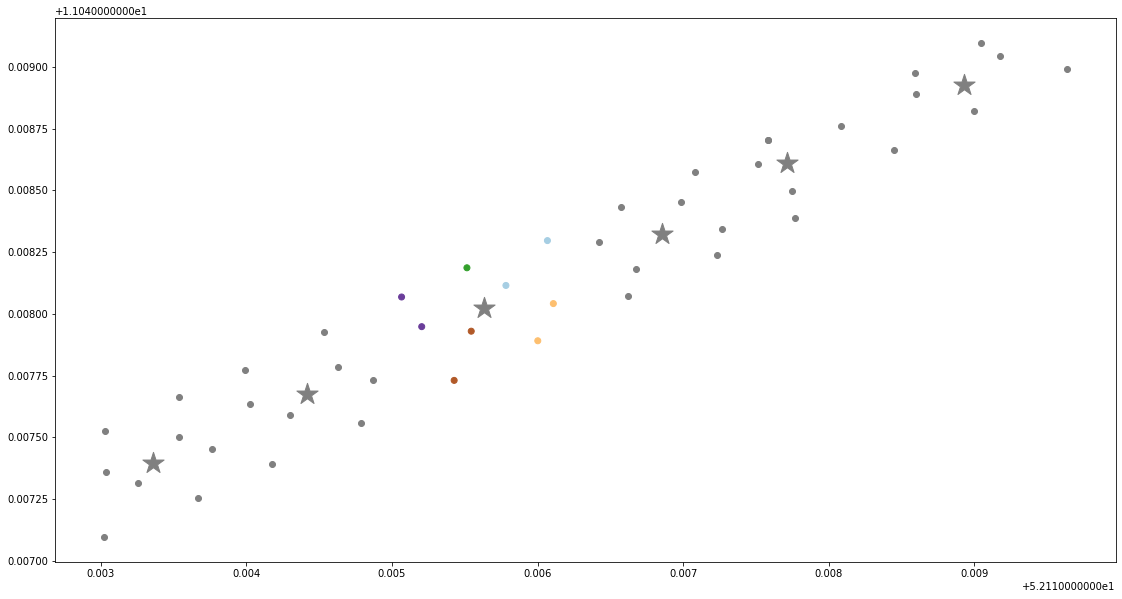

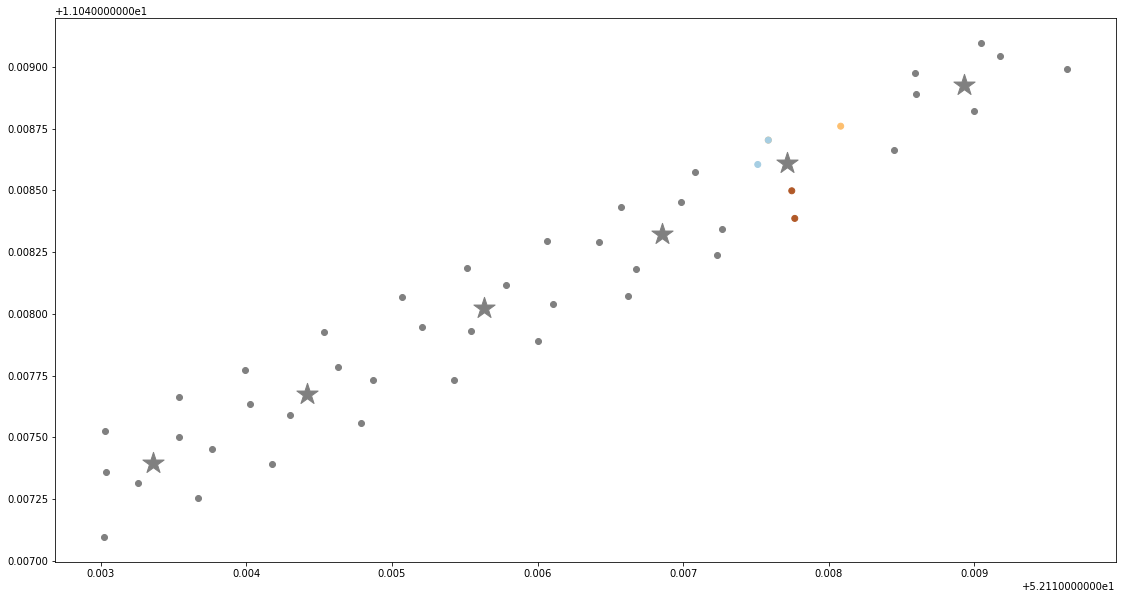

ExportBales_4.csv
14
5
Nombre de clusters : 3 inertie : 2.057840513381198e-05
     latitude  longitude  cluster
0   52.110716  11.068745        0
1   52.110830  11.067944        0
2   52.111260  11.067398        0
3   52.111229  11.067419        0
4   52.111358  11.066010        0
5   52.111628  11.064322        2
6   52.112273  11.063083        2
7   52.112152  11.062835        1
8   52.112001  11.063586        2
9   52.112200  11.060284        1
10  52.111121  11.061899        1
11  52.110838  11.064384        2
12  52.110838  11.064384        2
13  52.108585  11.061234        1


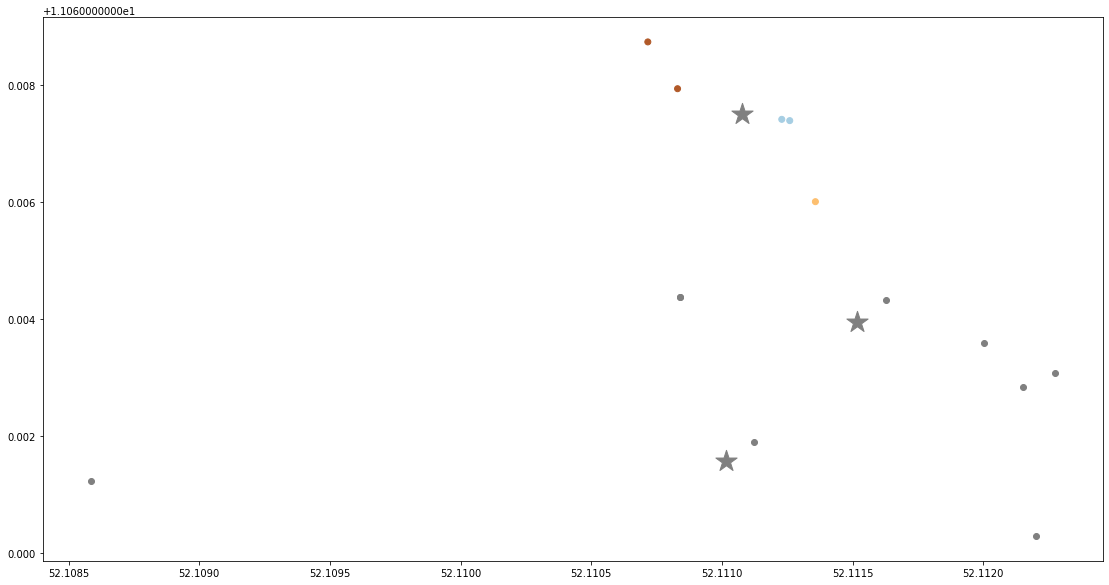

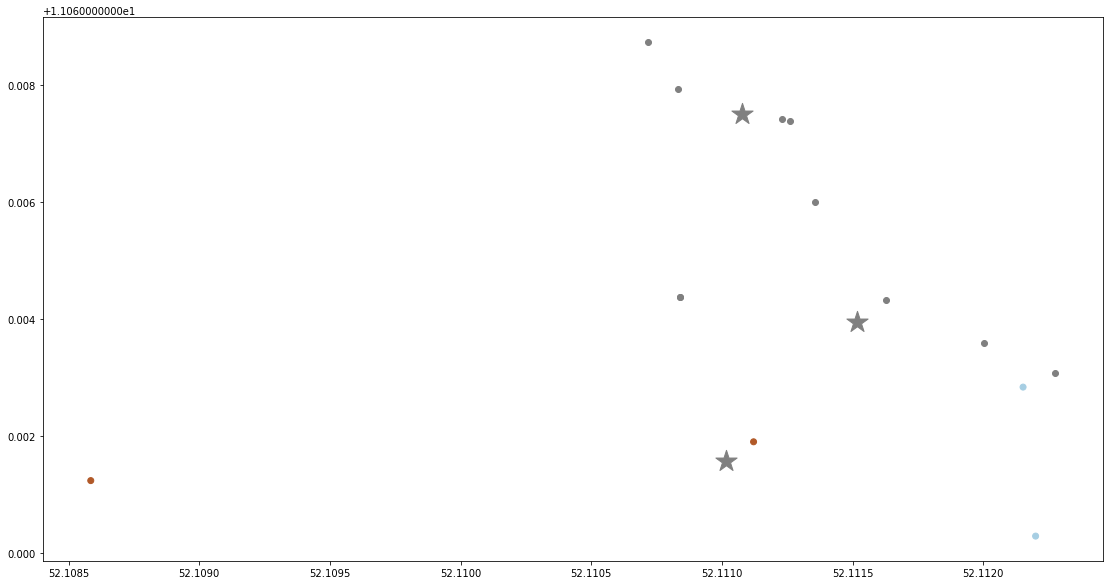

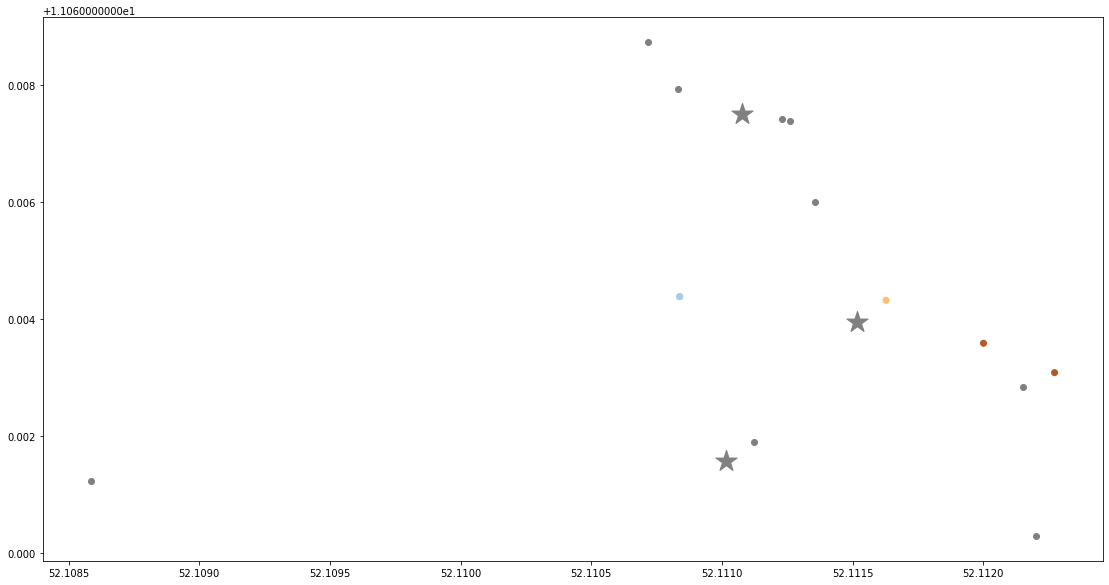

In [6]:
for key in dfs.keys():
    print(key)
    df = dfs[key]
    print(df.shape[0])
    taille_remorque = max(df.shape[0]//5, 5)
    print(taille_remorque)
    clustering(dfs[key], key, size_trailer=taille_remorque)

In [7]:
for key in dfs.keys():
    print(dfs[key]["bale_info_moisture"].unique())

[110000]
[110000]
[110000]
[110000]
[110000]


In [8]:
clustering(dfs['ExportBales.csv'], 'ExportBales.csv', size_trailer=30, humidite_lim=(0.15, 0.20))

TypeError: clustering() got an unexpected keyword argument 'humidite_lim'

Nombre de clusters : 3 inertie : 2.0967124559999005e-06
     latitude  longitude  cluster
0   52.116077  11.083267        0
1   52.116089  11.085686        2
2   52.116138  11.084403        1
3   52.116165  11.083136        0
4   52.116232  11.083386        0
5   52.116208  11.084310        1
6   52.116166  11.085495        2
7   52.116275  11.085149        2
8   52.116293  11.084331        1
9   52.116326  11.083135        0
10  52.116405  11.082807        0
11  52.116376  11.083880        1
12  52.116357  11.084805        2
13  52.116440  11.084763        2
14  52.116478  11.083629        1
15  52.116502  11.082610        0
16  52.116549  11.083111        0
17  52.116512  11.084755        2


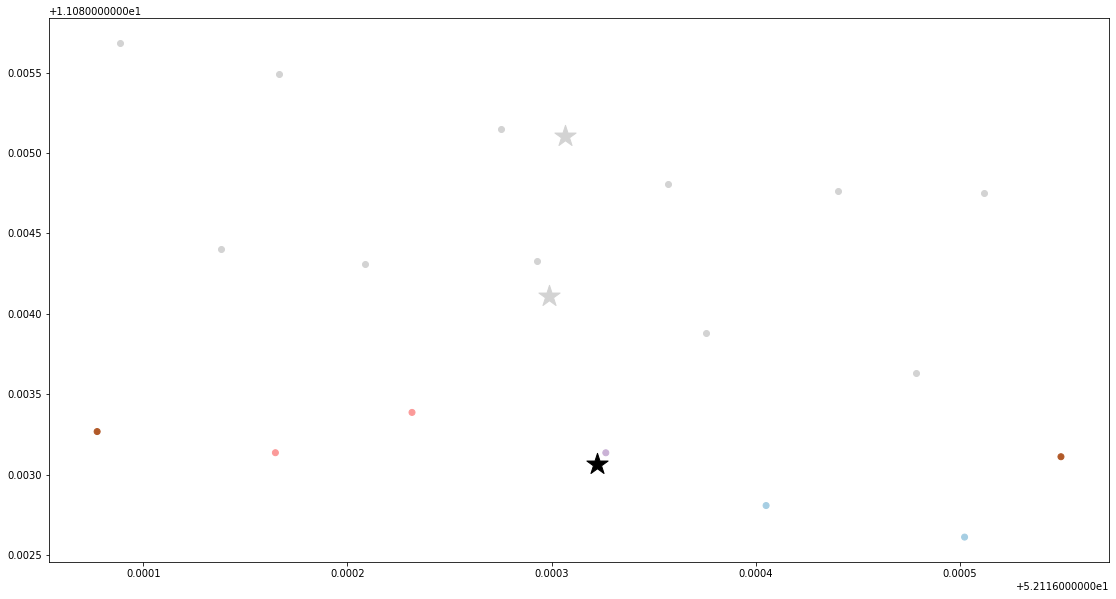

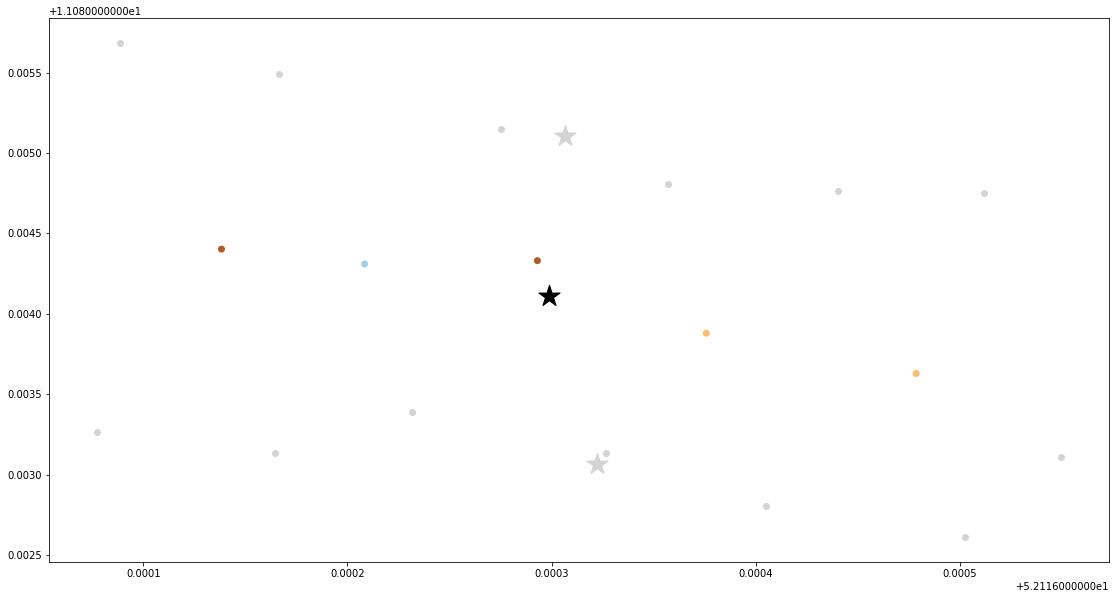

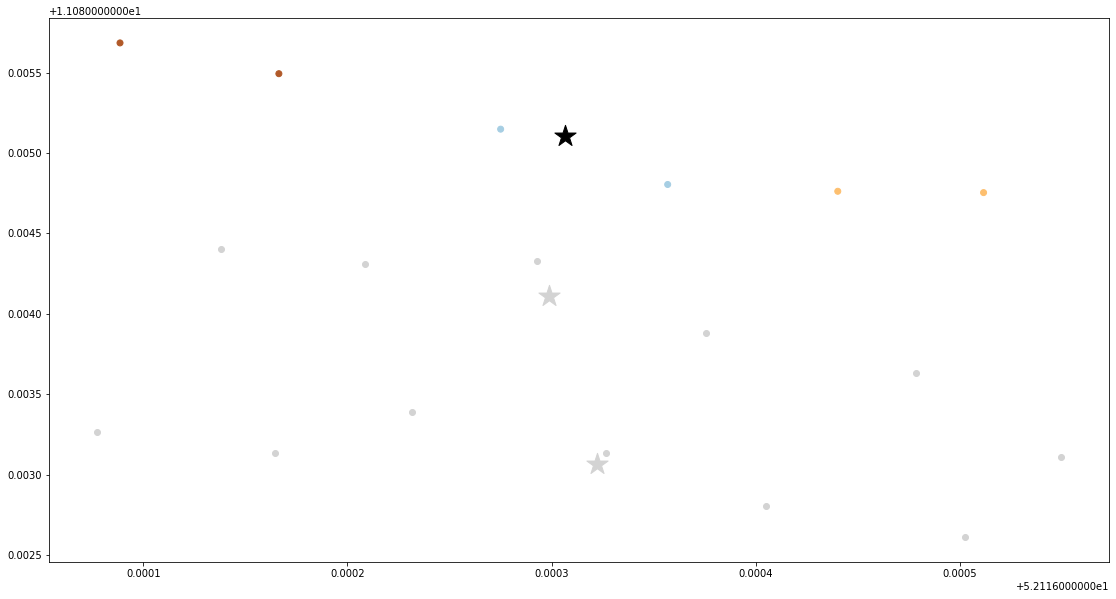

In [21]:
clustering(dfs['ExportBales_2.csv'], 'ExportBales.csv', size_trailer=7)